In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          wind_gyre_forcing,run_model, compute_dt_cfl)
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import math

def save_every_for_target_frames(tmax, dt, n_frames, include_initial=True):
    """
    Choose a save_every stride to produce about n_frames snapshots over [0, tmax].
    """
    if n_frames <= 1:
        # only initial (or final) frame
        return max(1, math.ceil(tmax/dt))  # save at start; plot just one frame
    N = math.ceil(tmax / dt)
    intervals = (n_frames - 1) if include_initial else n_frames
    return max(1, int(round(N / intervals)))


In [23]:
# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 2.0e6, 2.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

params = ModelParams(
    H=1000.0, g=9.81, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=1/(12*86400),    # a bit more damping than linear case
    linear=True,       # <— enable nonlinear terms
    # Ah=200.0          # (optional) lateral viscosity if needed
)

dt = compute_dt_cfl(grid, params, cfl=0.5)
tmax = 10 * 86400.0
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")
forcing_fn = lambda t, g, p: wind_gyre_forcing(t, g, p, tau0=0.1)
 
out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"))

print('Saved steps:', len(out['time']))


Saved steps: 120


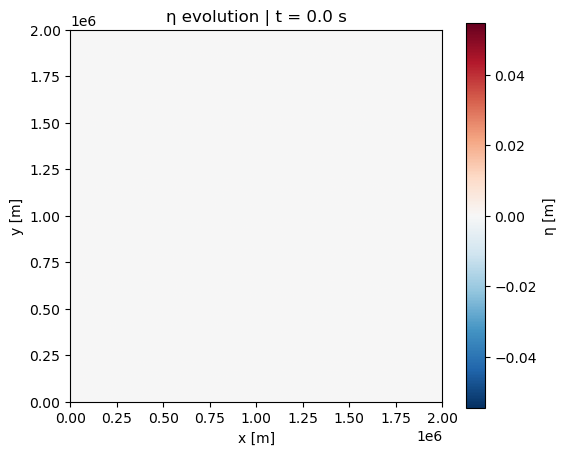

In [24]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_01.gif", fps=10)

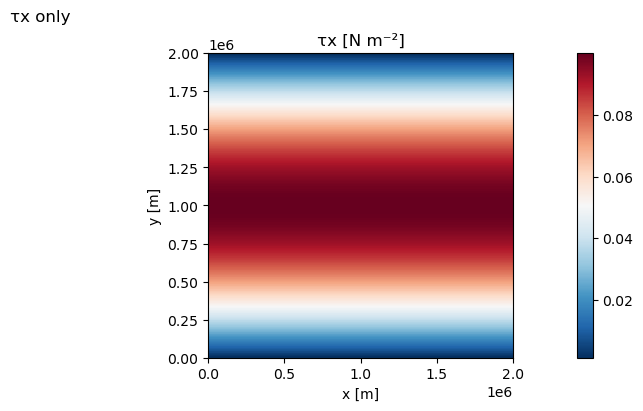

In [19]:
from shallowwater.visualize import plot_forcings

fig_tx = plot_forcings(forcing_fn, t=0.0, grid=grid, params=params, what="taux",
                       title="τx only")

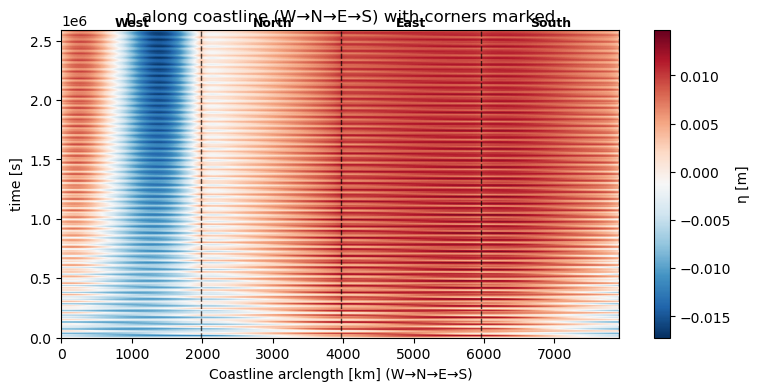

In [12]:
from shallowwater.visualize import coast_hovmoller

fig = coast_hovmoller(out, grid, units_x="km",
                      title="η along coastline (W→N→E→S) with corners marked")

### nonlinear case (momentum advection + lateral viscosity)

#### something is not working... gets unstable, but was working well before. Problem appeared when numba was introduced.

In [5]:
# Grid & params
Nx, Ny = 128, 128
Lx, Ly = 2.0e6, 2.0e6
grid = make_grid(Nx, Ny, Lx, Ly)

params = ModelParams(
    H=1000.0, g=9.81, rho=1025.0,
    f0=1e-4, beta=2e-11, y0=Ly/2,
    r=1/(12*86400),    # a bit more damping than linear case
    linear=False,       # <— enable nonlinear terms
    Ah=200.0,          # (optional) lateral viscosity if needed
    Hmin_frac=0.02       # clip min thickness at 2% H
)

dt = compute_dt_cfl(grid, params, cfl=0.03)
tmax = 10 * 86400.0
save_every = save_every_for_target_frames(tmax, dt, n_frames=120)

ic_fn = lambda g, p: setup_initial_state(g, p, mode="rest")
forcing_fn = lambda t, g, p: wind_gyre_forcing(t, g, p, tau0=0.1)

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"))

print('Saved steps:', len(out['time']))


Saved steps: 120


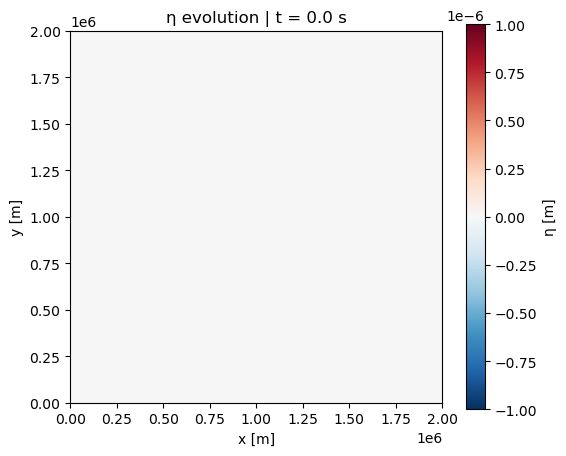

In [6]:
# Quick look animation (if you added visualize.py earlier)
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=120, title="η evolution")

# GIF (no external dependencies)
anim.save("eta_01b_nonlinear.gif", fps=10)